# Multi-Class Prediction of Obesity Risk Kaggle Competition

This notebook covers the [Multi-Class Prediction of Obesity Risk Kaggle Competition](https://www.kaggle.com/competitions/playground-series-s4e2). In this problem, we are to predict obesity risk (column NObeyesdad) given a variety of factors on each person. The data is generated from [this actual dataset](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster/data). Descriptions for the non-obvious columns are below:

* history - family member suffered or suffers from overweight
* FAVC - Frequent consumption of high caloric food
* FCVC - Frequency of consumption of vegetables
* NCP - Number of main meals
* CAEC - Consumption of food between meals
* SMOKE - Smoker or not
* CH2O - Consumption of water daily
* SCC - Calories consumption monitoring
* FAF - Physical activity frequency
* TUE - Time using technology devices
* CALC - Consumption of alcohol
* MTRANS - Transportation used

Let's begin by reading in the data

In [1]:
import warnings
warnings.filterwarnings("ignore") # Ignores pandas warnings within Seaborn

import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set_theme()

df = pd.read_csv("train.csv").rename(columns={'family_history_with_overweight': 'history'})
df.head().round(2)

,id,Gender,Age,Height,Weight,history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,Sometimes,no,2.76,no,0.00,0.98,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,Frequently,no,2.00,no,1.00,1.00,no,Automobile,Normal_Weight
2,2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,Sometimes,no,1.91,no,0.87,1.67,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,Sometimes,no,1.67,no,1.47,0.78,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,Sometimes,no,1.98,no,1.97,0.93,Sometimes,Public_Transportation,Overweight_Level_II


Nearly 21k samples in the training set.

In [2]:
df.shape

(20758, 18)

Before getting started, it's important to note that the categorizations we are looking for are nearly provided for us using BMI (body mass index) from the original dataset:

NObesity values are:
* Underweight Less than 18.5
* Normal 18.5 to 24.9
* Overweight 25.0 to 29.9
* Obesity I 30.0 to 34.9
* Obesity II 35.0 to 39.9
* Obesity III Higher than 40

BMI is calculated as weight divided by height squared. This same classification can be found [here on Wikipedia](https://en.wikipedia.org/wiki/Classification_of_obesity).

The actual classifications found in this dataset are nearly the same, but with an additional level for Overweight II.

In [3]:
df['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

To make the classifications sortable, convert to an ordered categorical in pandas.

In [4]:
weight_cats = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 
               'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
df['NObeyesdad'] = df['NObeyesdad'].astype(pd.CategoricalDtype(weight_cats, ordered=True))

As the classification names are quite long, we rename them here.

In [5]:
rename_weights = {
    'Insufficient_Weight': 'Insuf', 
    'Normal_Weight': 'Normal', 
    'Overweight_Level_I': 'Over_I', 
    'Overweight_Level_II': 'Over_II', 
    'Obesity_Type_I': 'Obese_I', 
    'Obesity_Type_II': 'Obese_II', 
    'Obesity_Type_III': 'Obese_III'
}
df['target'] = df['NObeyesdad'].replace(rename_weights)

For many scientific studies, categorization is based entirely on BMI. Let's create this feature and then plot BMI for each category by gender.

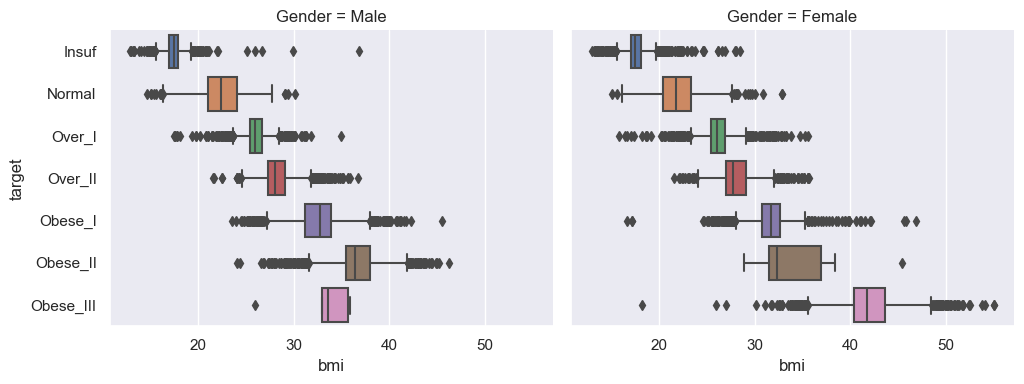

In [6]:
df['bmi'] = df['Weight'] / df['Height'] ** 2
sns.catplot(df, x='bmi', y='target', col='Gender', kind='box', aspect=1.3, height=4);

While the inner quartile range of the boxplots are nearly perfectly separable, there is a lot of overlap amongst the outliers. I do find it hard to believe that there are individuals with a bmi of over 35 that are considered insufficient weight. Similarly, there is an individual with a BMI less than 20 that is Obese_III. These outliers are likely a product of how the data was generated (randomly through a deep learning model). This problem wouldn't be very interesting if each person were neatly categorized by BMI. I suspect the test data is also from the same distribution, so we'll have to attempt to learn from this messy categorization.

The strangest result from above is the Obese_III BMI for males is lower than Obese_II. Let's take a look athe counts in each group.

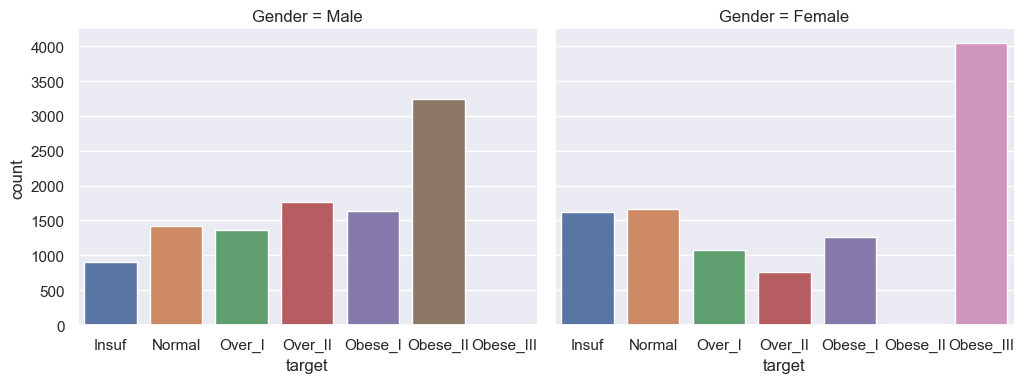

In [7]:
sns.catplot(df, x='target', col='Gender', kind='count', height=4, aspect=1.3);

Getting exact numbers, nearly all Obese_II are male and all Obese_III are female. Again, makes no sense and is likely a product of how the data was generated.

In [8]:
pd.crosstab(index=df['Gender'], columns=df['target'])

target,Insuf,Normal,Over_I,Over_II,Obese_I,Obese_II,Obese_III
Gender,,,,,,,
Female,1621,1660,1070,755,1267,8,4041
Male,902,1422,1357,1767,1643,3240,5


Looking at the middle 50% of the BMI for each gender, it appears there is a clean separation.

In [9]:
df.groupby(['Gender', 'NObeyesdad'])['bmi'].quantile([0.25, 0.75]).unstack(level=[0,2]).round(1)

Gender              Female        Male      
                      0.25  0.75  0.25  0.75
NObeyesdad                                  
Insufficient_Weight   17.1  18.1  17.0  17.9
Normal_Weight         20.4  23.3  21.0  24.1
Overweight_Level_I    25.4  26.9  25.5  26.7
Overweight_Level_II   27.0  29.0  27.3  29.1
Obesity_Type_I        30.8  32.7  31.2  33.9
Obesity_Type_II       31.4  36.9  35.4  38.0
Obesity_Type_III      40.4  43.6  32.9  35.7

To more easily see if there is a difference between male and females, plot them together. Only Obese_II and Obese_III show significant separation.

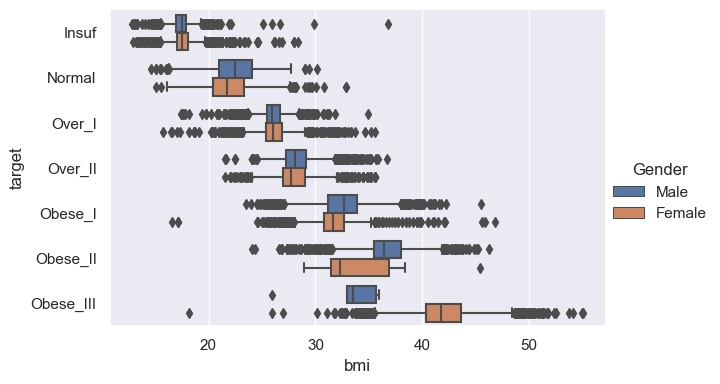

In [10]:
sns.catplot(df, x='bmi', y='target', hue='Gender', kind='box', aspect=1.6, height=4);

Let's divide age into 5 categories and look at the counts by gender and category. Ageing appears correlated to obesity.

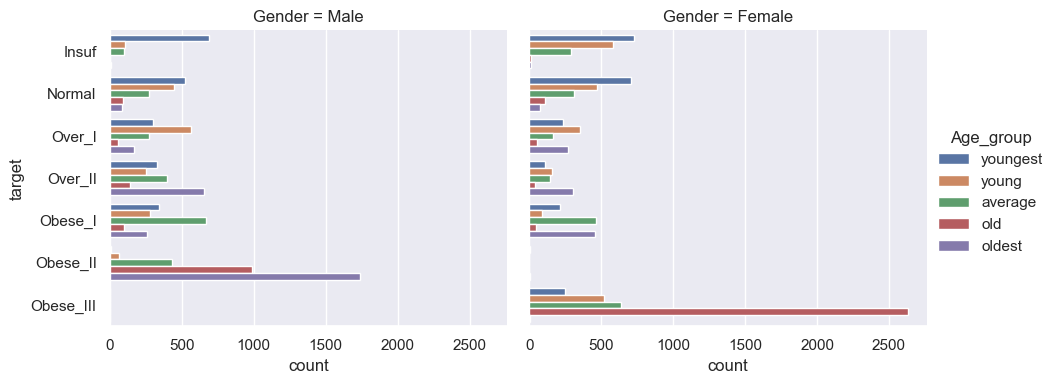

In [11]:
df['Age_group'] = pd.qcut(df['Age'], 5, labels=['youngest', 'young', 'average', 'old', 'oldest'])
sns.catplot(df, y='target', hue='Age_group', col='Gender', kind='count', aspect=1.2, height=4);

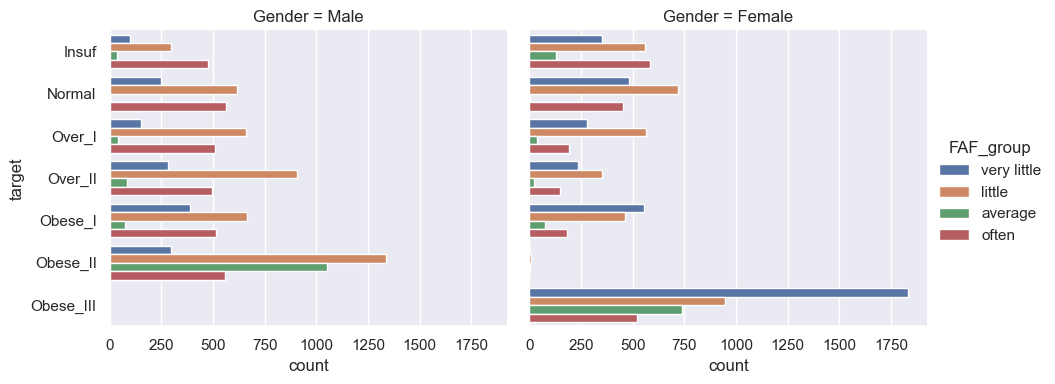

In [12]:
df['FAF_group'] = pd.qcut(df['FAF'], 4, labels=['very little', 'little', 'average', 'often'])
sns.catplot(df, y='target', hue='FAF_group', col='Gender', kind='count', aspect=1.2, height=4);

Not much separation by Physical activity frequency.

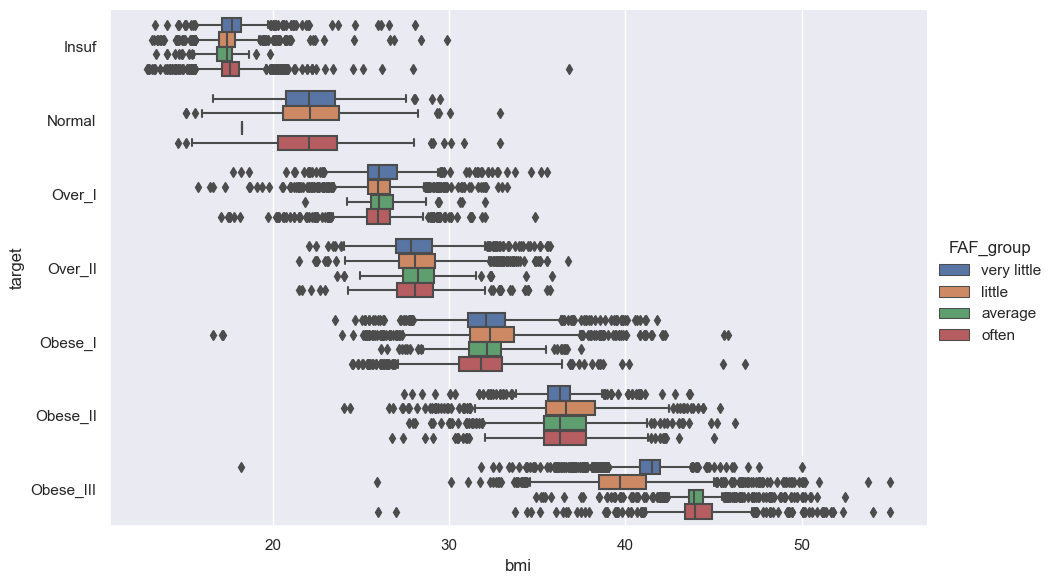

In [13]:
sns.catplot(df, x='bmi', y='target', hue='FAF_group', kind='box', aspect=1.6, height=6);

### Build simple rule-based model

Build custom estimator that takes a list of BMI cut points and predicts the class. For the last two classes, gender is used. The column names (bmi__BMI, gender__Gender) come from the column transformer upcoming, which appends the transformer name to the start of the column name.

In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
class BMIRuleEstimator(ClassifierMixin, BaseEstimator):
    
    def __init__(self, *, cut_points=[18.5, 25, 27.5, 30, 35]):
        self.cut_points = cut_points
        
    def fit(self, X, y=None):
        # There is no learning with this estimator, it is completely rule based
        self.is_fitted_ = True
        return self

    def predict(self, X):
        bmi = X['bmi__BMI']
        gender = X['gender__Gender']
        return np.where(bmi < self.cut_points[0], 'Insufficient_Weight',
                            np.where(bmi < self.cut_points[1], 'Normal_Weight',
                                 np.where(bmi < self.cut_points[2], 'Overweight_Level_I',
                                          np.where(bmi < self.cut_points[3], 'Overweight_Level_II',
                                                   np.where(bmi < self.cut_points[4], 'Obesity_Type_I',
                                                            np.where(gender == "Male", 'Obesity_Type_II', 'Obesity_Type_III'))))))

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Build a custom transformer for BMI

Only three columns, gender, weight, and height are used in the model. Here, we create a custom tranformer to create BMI. Gender is left untransformed via "passthrough".

In [16]:
def calc_bmi(df):
    s = df['Weight'] / df['Height'] ** 2
    return s.to_frame('BMI')
    
bmi_cols = ['Height', 'Weight']
gender_col = ['Gender']

ft = FunctionTransformer(calc_bmi, feature_names_out=lambda self, names: ['BMI'])
ct = ColumnTransformer([('gender', "passthrough", gender_col),
                        ('bmi', ft, bmi_cols)
                       ])
ct.set_output(transform="pandas")

ColumnTransformer(transformers=[('gender', 'passthrough', ['Gender']),
                                ('bmi',
                                 FunctionTransformer(feature_names_out=<function <lambda> at 0x1650877e0>,
                                                     func=<function calc_bmi at 0x165087d80>),
                                 ['Height', 'Weight'])])

Test that the column transformer works.

In [17]:
ct.fit_transform(df).head()

,gender__Gender,bmi__BMI
0,Male,28.259565
1,Female,23.422091
2,Female,17.126706
3,Female,44.855798
4,Male,25.599151


### Build a pipeline

Transform the columns then fit with rule-based estimator.

In [18]:
pipe = Pipeline([('column_transformers', ct), ('bre', BMIRuleEstimator())])

### Grid search different cut points

In [19]:
gscv = GridSearchCV(pipe, param_grid={'bre__cut_points': [[18.5, 25, 27.5, 30, 35],
                                                         [20, 25, 30, 35, 40]]})
gscv.fit(df, df['NObeyesdad'])

GridSearchCV(estimator=Pipeline(steps=[('column_transformers',
                                        ColumnTransformer(transformers=[('gender',
                                                                         'passthrough',
                                                                         ['Gender']),
                                                                        ('bmi',
                                                                         FunctionTransformer(feature_names_out=<function <lambda> at 0x1650877e0>,
                                                                                             func=<function calc_bmi at 0x165087d80>),
                                                                         ['Height',
                                                                          'Weight'])])),
                                       ('bre', BMIRuleEstimator())]),
             param_grid={'bre__cut_points': [[18.5, 25, 27.5, 30, 35],
                                             [20, 25, 30, 35, 40]]})

Show results - notice how much greater

In [20]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bre__cut_points,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003915,0.000643,0.004487,0.000888,"[18.5, 25, 27.5, 30, 35]","{'bre__cut_points': [18.5, 25, 27.5, 30, 35]}",0.816956,0.818160,0.822254,0.828234,0.815466,0.820214,0.004601,1
1,0.002669,0.000083,0.003103,0.000049,"[20, 25, 30, 35, 40]","{'bre__cut_points': [20, 25, 30, 35, 40]}",0.501686,0.507466,0.502890,0.496025,0.505661,0.502746,0.003927,2


## Read in test data and fit

In [21]:
df_test = pd.read_csv("test.csv").rename(columns={'family_history_with_overweight': 'history'})
df_test.head()

,id,Gender,Age,Height,Weight,history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [22]:
gscv.best_estimator_.fit(df_test)

Pipeline(steps=[('column_transformers',
                 ColumnTransformer(transformers=[('gender', 'passthrough',
                                                  ['Gender']),
                                                 ('bmi',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x1650877e0>,
                                                                      func=<function calc_bmi at 0x165087d80>),
                                                  ['Height', 'Weight'])])),
                ('bre', BMIRuleEstimator())])

Save and submit

In [23]:
from datetime import datetime

def write_prediction(data, model):
    y_pred = model.predict(data)
    df_pred = pd.DataFrame({'id': data['id'], 'NObeyesdad': y_pred})
    time = datetime.today().strftime('%Y-%m-%d:%H:%M%s')[:16]
    df_pred.to_csv(f"submissions/{time}.csv", index=False)
    return df_pred

In [24]:
df_pred = write_prediction(df_test, gscv.best_estimator_)
df_pred.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_II
4,20762,Obesity_Type_III


## Build more complex model

Here, we use all columns, transforming the categorical, ordinal, numeric, and creating BMI separatelty with the help of the `ColumnTransformer`.

In [25]:
cat_cols = ['Gender', 'history', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
ord_cols = ['CAEC', 'CALC']
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
bmi_cols = ['Height', 'Weight']

In [26]:
ct = ColumnTransformer([('categories', OneHotEncoder(sparse_output=False), cat_cols),
                   ('ordinal', OrdinalEncoder(categories=[['no', 'Sometimes', 'Frequently', 'Always']] * 2), ord_cols),
                   ('numeric', StandardScaler(), numeric_cols),
                   ('bmi', ft, bmi_cols)
                       ])

## Fit with a Random Forest

In [27]:
pipe = Pipeline([('column_transformers', ct), ('rfc', RandomForestClassifier())])
pipe

Pipeline(steps=[('column_transformers',
                 ColumnTransformer(transformers=[('categories',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Gender', 'history', 'FAVC',
                                                   'SMOKE', 'SCC', 'MTRANS']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always'],
                                                                             ['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always']]),
                                                  ['CAEC', 'CALC']),
                                                 ('numeric', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('bmi',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x1650877e0>,
                                                                      func=<function calc_bmi at 0x165087d80>),
                                                  ['Height', 'Weight'])])),
                ('rfc', RandomForestClassifier())])

In [28]:
gscv = GridSearchCV(pipe, param_grid={'rfc__max_depth': range(6, 10), 'rfc__n_estimators': [1000]})
gscv.fit(df, df['NObeyesdad'])

GridSearchCV(estimator=Pipeline(steps=[('column_transformers',
                                        ColumnTransformer(transformers=[('categories',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['Gender',
                                                                          'history',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'MTRANS']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(categories=[['no',
                                                                                                     'Sometimes',
                                                                                                     'Frequently',
                                                                                                     'Always'],
                                                                                                    ['no',
                                                                                                     'Sometimes',
                                                                                                     'Frequently',
                                                                                                     'Always']]),
                                                                         ['CAEC',
                                                                          'CALC']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Height',
                                                                          'Weight',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE']),
                                                                        ('bmi',
                                                                         FunctionTransformer(feature_names_out=<function <lambda> at 0x1650877e0>,
                                                                                             func=<function calc_bmi at 0x165087d80>),
                                                                         ['Height',
                                                                          'Weight'])])),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': range(6, 10),
                         'rfc__n_estimators': [1000]})

In [29]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.308791,0.080508,0.234837,0.003317,6,1000,"{'rfc__max_depth': 6, 'rfc__n_estimators': 1000}",0.879094,0.874759,0.881503,0.887497,0.881474,0.880866,0.004127,4
1,8.103839,0.115948,0.254696,0.001451,7,1000,"{'rfc__max_depth': 7, 'rfc__n_estimators': 1000}",0.885356,0.884152,0.891378,0.890870,0.888220,0.887995,0.002880,3
2,8.931120,0.047170,0.275160,0.002554,8,1000,"{'rfc__max_depth': 8, 'rfc__n_estimators': 1000}",0.887765,0.889451,0.894027,0.895206,0.893761,0.892042,0.002895,2
3,9.599304,0.041143,0.299987,0.002095,9,1000,"{'rfc__max_depth': 9, 'rfc__n_estimators': 1000}",0.890896,0.889933,0.898844,0.896892,0.897615,0.894836,0.003676,1


In [30]:
write_prediction(df_test, gscv.best_estimator_)

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight
